# S1 Coursework

Yuanzhen Zhao (yz929)

In [2]:
import numpy as np
from scipy.integrate import quad, dblquad
import matplotlib.pyplot as plt
from iminuit import Minuit
from iminuit.cost import ExtendedUnbinnedNLL, BinnedNLL, ExtendedBinnedNLL, UnbinnedNLL
from dists import *
from scipy.optimize import brute
from sweights import SWeight
from scipy.stats import crystalball as sp_crystalball # as numba_stats.crystalball does not have ppf function
from tqdm import tqdm

In [3]:
# Parameters
mu, sigma, beta, m, f, lmda, mu_b, sigma_b = 3.0, 0.3, 1.0, 1.4, 0.6, 0.3, 0.0, 2.5

## Question b

In [4]:
# Check if normalisation is satisfied
print(f"Area of g_s for x in [0, 5] evaluates to {quad(g_s, 0., 5., args=(beta, m, mu, sigma))[0]}")
print(f"Area of h_s for y in [0, 10] evaluates to {quad(h_s, 0., 10., args=(lmda,))[0]}")
print(f"Area of g_b for x in [0, 5] evaluates to {quad(g_b, 0., 5.)[0]}")
print(f"Area of h_b for y in [0, 10] evaluates to {quad(h_b, 0., 10., args=(mu_b, sigma_b))[0]}")
print(f"Area of s_xy for x in [0, 5] & y in [0, 10] evaluates to {dblquad(s_xy, 0., 5., 0., 10., args=(beta, m, mu, sigma, lmda))[0]}")
print(f"Area of b_xy for x in [0, 5] & y in [0, 10] evaluates to {dblquad(b_xy, 0., 5., 0., 10., args=(mu_b, sigma_b))[0]}")
print(f"Area of f_xy for x in [0, 5] & y in [0, 10] evaluates to {dblquad(f_xy, 0., 5., 0., 10., args=(mu, sigma, beta, m, f, lmda, mu_b, sigma_b))[0]}")

Area of g_s for x in [0, 5] evaluates to 1.000000037626072
Area of h_s for y in [0, 10] evaluates to 1.0
Area of g_b for x in [0, 5] evaluates to 1.0000000000000002
Area of h_b for y in [0, 10] evaluates to 1.0
Area of s_xy for x in [0, 5] & y in [0, 10] evaluates to 1.000000037626072
Area of b_xy for x in [0, 5] & y in [0, 10] evaluates to 1.0000000000000002
Area of f_xy for x in [0, 5] & y in [0, 10] evaluates to 1.0000000225756434


## Question c

In [5]:
x = np.linspace(0, 5, 200)
y = np.linspace(0, 10, 200)

P_x = f * g_s(x, beta, m, mu, sigma) + (1-f) * g_b(x)
P_y = f * h_s(y, lmda) + (1-f) * h_b(y, mu_b, sigma_b)

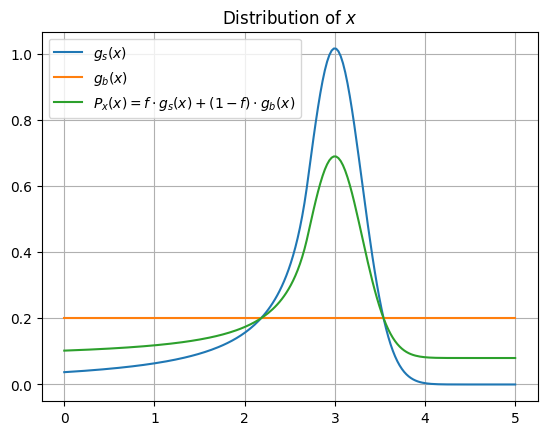

In [6]:
plt.plot(x, g_s(x, beta, m, mu, sigma), label='$g_s(x)$')
plt.plot(x, g_b(x), label='$g_b(x)$')
plt.plot(x, P_x, label='$P_x(x) = f \\cdot g_s(x) + (1-f) \\cdot g_b(x)$')
plt.title('Distribution of $x$')
plt.grid()
plt.legend()
plt.show()

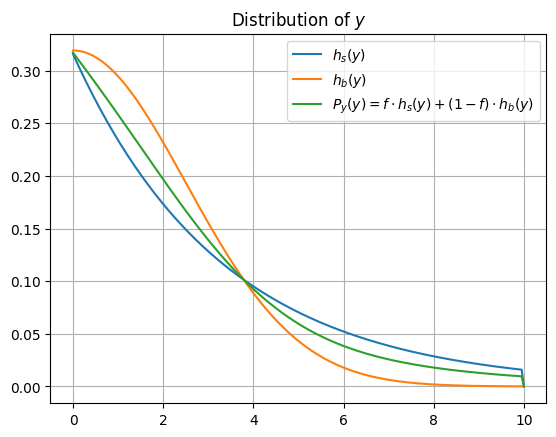

In [7]:
plt.plot(y, h_s(y, lmda), label='$h_s(y)$')
plt.plot(y, h_b(y, mu_b, sigma_b), label='$h_b(y)$')
plt.plot(y, P_y, label='$P_y(y) = f \\cdot h_s(y) + (1-f) \\cdot h_b(y)$')
plt.title('Distribution of $y$')
plt.grid()
plt.legend()
plt.show()

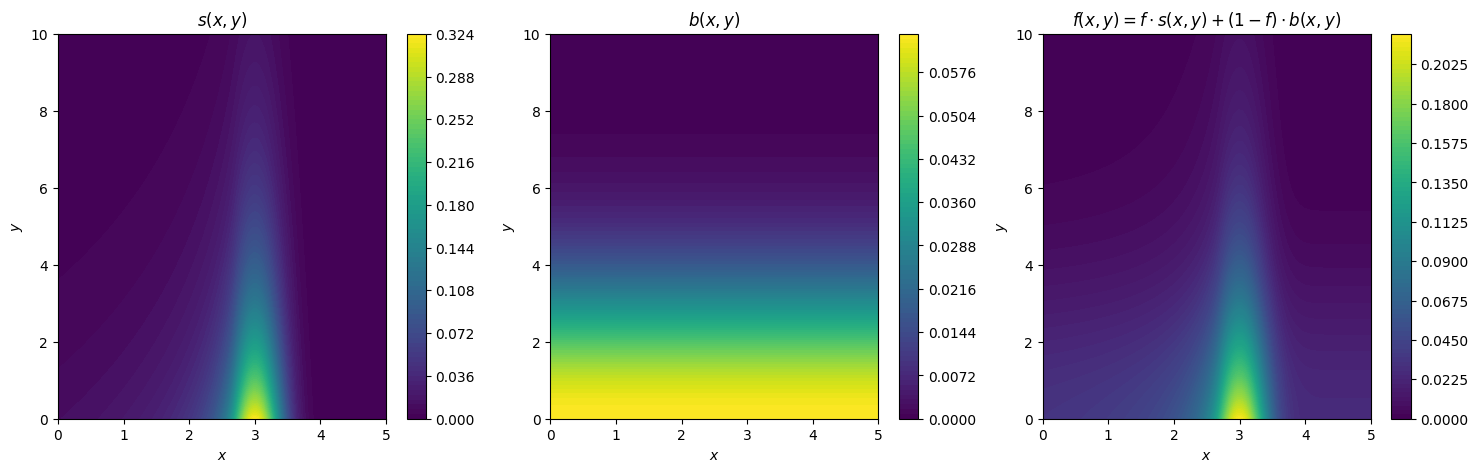

In [12]:
X, Y = np.meshgrid(x, y)

fig, ax = plt.subplots(1, 3, figsize=(18, 5))

sxy = ax[0].contourf(X, Y, s_xy(Y, X, beta, m, mu, sigma, lmda), levels=100)
ax[0].set_title('$s(x,y)$')
ax[0].set_xlabel('$x$')
ax[0].set_ylabel('$y$')
fig.colorbar(sxy, ax=ax[0])

bxy = ax[1].contourf(X, Y, b_xy(Y, X, mu_b, sigma_b), levels=100)
ax[1].set_title('$b(x,y)$')
ax[1].set_xlabel('$x$')
ax[1].set_ylabel('$y$')
fig.colorbar(bxy, ax=ax[1])

fxy = ax[2].contourf(X, Y, f_xy(Y, X, mu, sigma, beta, m, f, lmda, mu_b, sigma_b), levels=100)
ax[2].set_title('$f(x,y) = f \\cdot s(x,y) + (1-f) \\cdot b(x,y)$')
ax[2].set_xlabel('$x$')
ax[2].set_ylabel('$y$')
fig.colorbar(fxy, ax=ax[2])

plt.show()


## Question d

In [8]:
def unbinned_fit(samples, density, num_samples=100000):
    """Fit the model to the data using the unbinned likelihood method."""
    N = np.random.poisson(num_samples)
    nll = ExtendedUnbinnedNLL((samples[:, 0], samples[:, 1]), density)
    mi = Minuit(nll, mu=3, sigma=0.3, beta=1, m=1.4, f=0.6, lmda=0.3, mu_b=0, sigma_b=2.5, N=N)
    mi.migrad()
    mi.hesse()
    return mi

In [9]:
def density(xy, mu=3, sigma=0.3, beta=1, m=1.4, f=0.6, lmda=0.3, mu_b=0, sigma_b=2.5, N=100000):
    # Unpack the data
    x, y = xy
    return N, N*f_xy(y, x, mu, sigma, beta, m, f, lmda, mu_b, sigma_b)

Generating samples using inverse transform sampling

In [10]:
def inverse_transform_sampling(N, mu=3, sigma=0.3, beta=1, m=1.4, f=0.6, lmda=0.3, mu_b=0, sigma_b = 2.5):
    """Generate N samples from the joint distribution f_xy(x, y) using the inverse transform sampling method."""
    Ns = int(f * N)
    Nb = int((1-f) * N)
    
    g_s_model = sp_crystalball(beta=beta, m=m, loc=mu, scale=sigma)
    g_s_uniform_samples = np.random.uniform(g_s_model.cdf(0), g_s_model.cdf(5), size=Ns)
    Xs = g_s_model.ppf(g_s_uniform_samples) # Make sure Xs are sampled in the range [0,5]

    g_b_uniform_samples = np.random.uniform(uniform.cdf(0, a = 0, w = 5), uniform.cdf(5, a = 0, w = 5), size=Nb)
    Xb = uniform.ppf(g_b_uniform_samples, a = 0, w = 5) # Make sure Xb are sampled in the range [0,5]
    
    Ys = truncexpon.rvs(xmin=0, xmax=10, loc=0, scale=1/lmda, size=Ns, random_state=None)
    Yb = truncnorm.rvs(xmin=0, xmax=10, loc=mu_b, scale=sigma_b, size=Nb, random_state=None)

    sevs = np.column_stack((Xs, Ys))
    bevs = np.column_stack((Xb, Yb))
    
    xyvalues = np.concatenate((sevs, bevs))
    
    return xyvalues

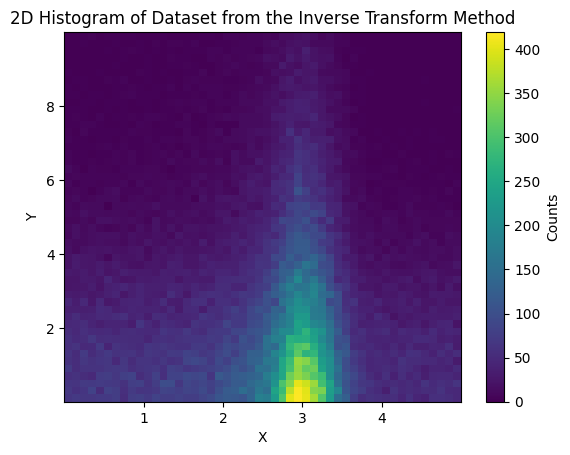

In [11]:
inverse_transform_sampling_dataset = inverse_transform_sampling(100000)

plt.hist2d(inverse_transform_sampling_dataset[:, 0], inverse_transform_sampling_dataset[:, 1], bins=[50, 50], cmap='viridis')
plt.colorbar(label='Counts')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('2D Histogram of Dataset from the Inverse Transform Method')
plt.show()

In [12]:
mi = unbinned_fit(inverse_transform_sampling_dataset, density)
display(mi)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -1.461e+06                 │              Nfcn = 331              │
│ EDM = 5.78e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬─────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name    │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼─────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mu      │  3.0036   │  0.0026   │            │            │         │         │       │
│ 1 │ sigma   │  0.2995   │  0.0024   │            │            │         │         │       │
│ 2 │ beta    │   1.004   │   0.022   │            │            │         │         │       │
│ 3 │ m       │   1.41    │   0.06    │            │            │         │         │       │
│ 4 │ f       │   0.598   │   0.004   │            │            │         │         │       │
│ 5 │ lmda    │  0.2992   │  0.0021   │            │            │         │         │       │
│ 6 │ mu_b    │   0.07    │   0.08    │            │            │         │         │       │
│ 7 │ sigma_b │   2.474   │   0.035   │            │            │         │         │       │
│ 8 │ N       │ 100.00e3  │  0.32e3   │            │            │         │         │       │
└───┴─────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────────┬───────────────────────────────────────────────────────────────────────────────────────────┐
│         │        mu     sigma      beta         m         f      lmda      mu_b   sigma_b         N │
├─────────┼───────────────────────────────────────────────────────────────────────────────────────────┤
│      mu │  6.76e-06     -4e-6    -30e-6     54e-6     -0e-6     -0e-6     -2e-6      1e-6     -0e-6 │
│   sigma │     -4e-6  5.94e-06     25e-6    -51e-6      3e-6      0e-6     14e-6     -9e-6      0e-6 │
│    beta │    -30e-6     25e-6  0.000486   -1.2e-3  0.008e-3      1e-6    0.1e-3        -0         0 │
│       m │     54e-6    -51e-6   -1.2e-3   0.00393 -0.084e-3    -12e-6    -0.001    0.0003    -0.000 │
│       f │     -0e-6      3e-6  0.008e-3 -0.084e-3  1.26e-05      2e-6  0.047e-3 -0.028e-3        -0 │
│    lmda │     -0e-6      0e-6      1e-6    -12e-6      2e-6  4.24e-06     10e-6      4e-6     -0e-6 │
│    mu_b │     -2e-6     14e-6    0.1e-3    -0.001  0.047e-3     10e-6   0.00564   -0.0025     0.000 │
│ sigma_b │      1e-6     -9e-6        -0    0.0003 -0.028e-3      4e-6   -0.0025   0.00125   -0.0000 │
│       N │     -0e-6      0e-6         0    -0.000        -0     -0e-6     0.000   -0.0000     1e+05 │
└─────────┴───────────────────────────────────────────────────────────────────────────────────────────┘

In [13]:
# Store the estimates and errors of the parameters
inverse_transform_sampling_estimates = {
    'mu': {'value': mi.values['mu'], 'error': mi.errors['mu']},
    'sigma': {'value': mi.values['sigma'], 'error': mi.errors['sigma']},
    'beta': {'value': mi.values['beta'], 'error': mi.errors['beta']},
    'm': {'value': mi.values['m'], 'error': mi.errors['m']},
    'f': {'value': mi.values['f'], 'error': mi.errors['f']},
    'lmda': {'value': mi.values['lmda'], 'error': mi.errors['lmda']},
    'mu_b': {'value': mi.values['mu_b'], 'error': mi.errors['mu_b']},
    'sigma_b': {'value': mi.values['sigma_b'], 'error': mi.errors['sigma_b']}
}

Accept-Reject method

In [14]:
def find_max(func, xrange, yrange, **kwargs):
    """Find the maximum of a function with two arguments over a given range"""
    f = lambda xy: -func(xy[1], xy[0], **kwargs)
    X = brute(f, [xrange, yrange])
    fmax = -f(X)
    return fmax

In [15]:
f_xy_max = find_max(f_xy, [0, 5], [0, 10], mu = 3, sigma = 0.3, beta = 1, m = 1.4, f = 0.6, lmda = 0.3, mu_b = 0, sigma_b = 2.5)

In [16]:
def accept_reject(size):
    """Generate samples from f_xy using the accept-reject method"""
    num_random = 2000000
    x_values = np.random.uniform(0, 5, num_random)
    y_values = np.random.uniform(0, 10, num_random)
    f_values = f_xy(y_values, x_values, mu=3, sigma=0.3, beta=1, m=1.4, f=0.6, lmda=0.3, mu_b=0, sigma_b = 2.5)
    u_values = np.random.uniform(0, f_xy_max, num_random)
    
    valid = u_values < f_values
    
    valid_sample = np.column_stack((x_values[valid], y_values[valid]))
    
    return valid_sample[:size]

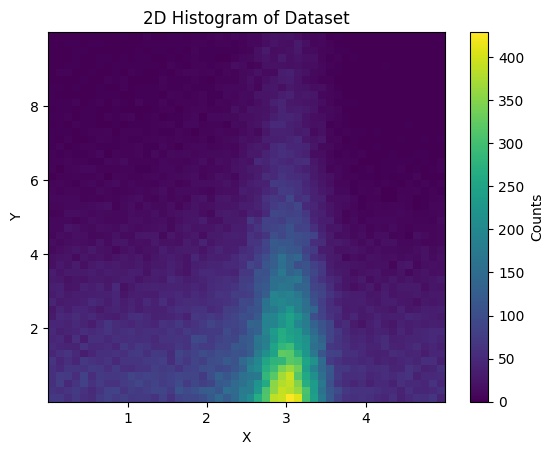

In [17]:
accept_reject_dataset = accept_reject(100000)
plt.hist2d(accept_reject_dataset[:, 0], accept_reject_dataset[:, 1], bins=[50, 50], cmap='viridis')
plt.colorbar(label='Counts')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('2D Histogram of Dataset')
plt.show()

In [18]:
mi = unbinned_fit(accept_reject_dataset, density)
display(mi)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -1.461e+06                 │              Nfcn = 283              │
│ EDM = 0.000756 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬─────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name    │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼─────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mu      │  3.0030   │  0.0026   │            │            │         │         │       │
│ 1 │ sigma   │  0.2960   │  0.0024   │            │            │         │         │       │
│ 2 │ beta    │   0.975   │   0.022   │            │            │         │         │       │
│ 3 │ m       │   1.43    │   0.06    │            │            │         │         │       │
│ 4 │ f       │  0.5975   │  0.0035   │            │            │         │         │       │
│ 5 │ lmda    │  0.3014   │  0.0021   │            │            │         │         │       │
│ 6 │ mu_b    │   0.07    │   0.08    │            │            │         │         │       │
│ 7 │ sigma_b │   2.466   │   0.035   │            │            │         │         │       │
│ 8 │ N       │ 100.00e3  │  0.32e3   │            │            │         │         │       │
└───┴─────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────────┬───────────────────────────────────────────────────────────────────────────────────────────┐
│         │        mu     sigma      beta         m         f      lmda      mu_b   sigma_b         N │
├─────────┼───────────────────────────────────────────────────────────────────────────────────────────┤
│      mu │  6.88e-06     -4e-6    -30e-6     56e-6     -0e-6     -0e-6     -2e-6      2e-6      0e-6 │
│   sigma │     -4e-6  6.02e-06     25e-6    -51e-6      3e-6      0e-6     15e-6     -9e-6     -0e-6 │
│    beta │    -30e-6     25e-6  0.000476   -1.2e-3  0.007e-3      0e-6    0.1e-3        -0        -0 │
│       m │     56e-6    -51e-6   -1.2e-3   0.00393 -0.080e-3    -10e-6    -0.001    0.0003     0.000 │
│       f │     -0e-6      3e-6  0.007e-3 -0.080e-3  1.25e-05      2e-6  0.047e-3 -0.029e-3        -0 │
│    lmda │     -0e-6      0e-6      0e-6    -10e-6      2e-6  4.26e-06     10e-6      4e-6     -0e-6 │
│    mu_b │     -2e-6     15e-6    0.1e-3    -0.001  0.047e-3     10e-6   0.00564   -0.0025    -0.000 │
│ sigma_b │      2e-6     -9e-6        -0    0.0003 -0.029e-3      4e-6   -0.0025   0.00126    0.0000 │
│       N │      0e-6     -0e-6        -0     0.000        -0     -0e-6    -0.000    0.0000     1e+05 │
└─────────┴───────────────────────────────────────────────────────────────────────────────────────────┘

In [19]:
# Store the estimates and errors of the parameters
accept_reject_estimates = {
    'mu': {'value': mi.values['mu'], 'error': mi.errors['mu']},
    'sigma': {'value': mi.values['sigma'], 'error': mi.errors['sigma']},
    'beta': {'value': mi.values['beta'], 'error': mi.errors['beta']},
    'm': {'value': mi.values['m'], 'error': mi.errors['m']},
    'f': {'value': mi.values['f'], 'error': mi.errors['f']},
    'lmda': {'value': mi.values['lmda'], 'error': mi.errors['lmda']},
    'mu_b': {'value': mi.values['mu_b'], 'error': mi.errors['mu_b']},
    'sigma_b': {'value': mi.values['sigma_b'], 'error': mi.errors['sigma_b']}
}

Evaluation of execution time averaged for 100 calls

In [21]:
benchmark_time = %timeit -o -n 100 -r 1 np.random.normal(size=100000)
inverse_transform_sampling_time = %timeit -o -n 100 -r 1 inverse_transform_sampling(100000)
accept_reject_time = %timeit -o -n 100 -r 1 accept_reject(100000)
fit_inverse_transform_sampling_time = %timeit -o -n 100 -r 1 unbinned_fit(inverse_transform_sampling_dataset, density)
fit_accept_reject_time = %timeit -o -n 100 -r 1 unbinned_fit(accept_reject_dataset, density)

1.35 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
9.01 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
142 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
2.72 s ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
2.59 s ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)


In [22]:
print(f"The benchmark time is {benchmark_time.average:.6f} seconds")
print(f"The inverse transform sampling time is {inverse_transform_sampling_time.average:.6f} seconds, which is about {inverse_transform_sampling_time.average/benchmark_time.average:.2f} times the benchmark time")
print(f"The accept-reject sampling time is {accept_reject_time.average:.6f} seconds, which is about {accept_reject_time.average/benchmark_time.average:.2f} times the benchmark time")
print(f"The fitting time for the inverse transform sampling dataset is {fit_inverse_transform_sampling_time.average:.6f} seconds, which is about {fit_inverse_transform_sampling_time.average/benchmark_time.average:.2f} times the benchmark time")
print(f"The fitting time for the accept-reject sampling dataset is {fit_accept_reject_time.average:.6f} seconds, which is about {fit_accept_reject_time.average/benchmark_time.average:.2f} times the benchmark time")

The benchmark time is 0.001349 seconds
The inverse transform sampling time is 0.009007 seconds, which is about 6.68 times the benchmark time
The accept-reject sampling time is 0.142235 seconds, which is about 105.46 times the benchmark time
The fitting time for the inverse transform sampling dataset is 2.716971 seconds, which is about 2014.41 times the benchmark time
The fitting time for the accept-reject sampling dataset is 2.585326 seconds, which is about 1916.80 times the benchmark time


## Question e

对于每个sample size(比如说500)，用d问得到的fitted parameters去**生成对应数量的simulation dataset，再重新拟合（初始值为d问params）**（粗体部分重复250次）

bias = mean(250次fit的value) - d问的lmda value

expected uncertainty = mean(250次fit的error)

In [22]:
sample_sizes = [500, 1000, 2500, 5000, 10000, 20000, 50000, 100000]
num_bootstrap = 250

In [23]:
mu_hat = inverse_transform_sampling_estimates['mu']['value']
sigma_hat = inverse_transform_sampling_estimates['sigma']['value']
beta_hat = inverse_transform_sampling_estimates['beta']['value']
m_hat = inverse_transform_sampling_estimates['m']['value']
f_hat = inverse_transform_sampling_estimates['f']['value']
lmda_hat = inverse_transform_sampling_estimates['lmda']['value']
mu_b_hat = inverse_transform_sampling_estimates['mu_b']['value']
sigma_b_hat = inverse_transform_sampling_estimates['sigma_b']['value']

In [24]:
def density_fitted_parameters(xy, N, lmda, mu=mu_hat, sigma=sigma_hat, beta=beta_hat, 
                              m=m_hat, f=f_hat, mu_b=mu_b_hat, sigma_b=sigma_b_hat):
    x, y = xy
    return N, N*f_xy(y, x, mu, sigma, beta, m, f, lmda, mu_b, sigma_b)


def unbinned_fit_with_fitted_parameters(samples, density, num_samples):
    N = np.random.poisson(num_samples)
    
    nll = ExtendedUnbinnedNLL((samples[:, 0], samples[:, 1]), density)
    mi = Minuit(nll, N=N, lmda=lmda_hat, mu=mu_hat, sigma=sigma_hat, beta=beta_hat, 
                            m=m_hat, f=f_hat, mu_b=mu_b, sigma_b=sigma_b_hat)
    
    mi.migrad()
    mi.hesse()
    return mi

In [25]:
# I use inverse transform sampling here as it is less computationally expensive

simulation_lmda_values = []
simulation_lmda_bias = []
simulation_lmda_uncertainty = []

for sample_size in sample_sizes:

    simulation_lmda_values_one_sample_size = []
    simulation_lmda_uncertainty_one_sample_size = []
    
    for _ in tqdm(range(num_bootstrap)):

        N = np.random.poisson(sample_size)
        
        simulation_dataset = inverse_transform_sampling(N, 
                                mu=mu_hat, sigma=sigma_hat, beta=beta_hat, m=m_hat, f=f_hat,
                                lmda=lmda_hat, mu_b=mu_b, sigma_b=sigma_b
                                    )
        
        simulation_mi = unbinned_fit_with_fitted_parameters(simulation_dataset, density_fitted_parameters, sample_size)

        simulation_lmda_values_one_sample_size.append(simulation_mi.values['lmda'])
        simulation_lmda_uncertainty_one_sample_size.append(simulation_mi.errors['lmda'])

    simulation_lmda_values.append(np.nanmean(simulation_lmda_values_one_sample_size))
    simulation_lmda_bias.append(np.nanmean(simulation_lmda_values_one_sample_size) - inverse_transform_sampling_estimates['lmda']['value'])
    simulation_lmda_uncertainty.append(np.nanmean(simulation_lmda_uncertainty_one_sample_size))

  0%|          | 0/250 [00:00<?, ?it/s]

100%|██████████| 250/250 [12:33<00:00,  3.01s/it]


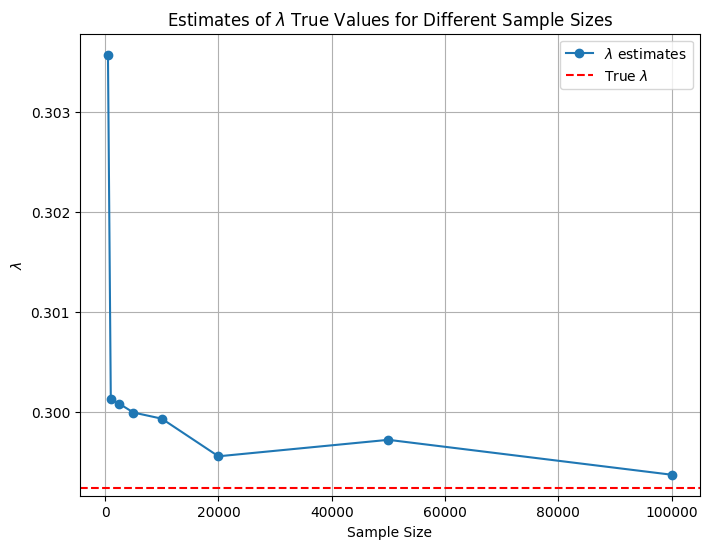

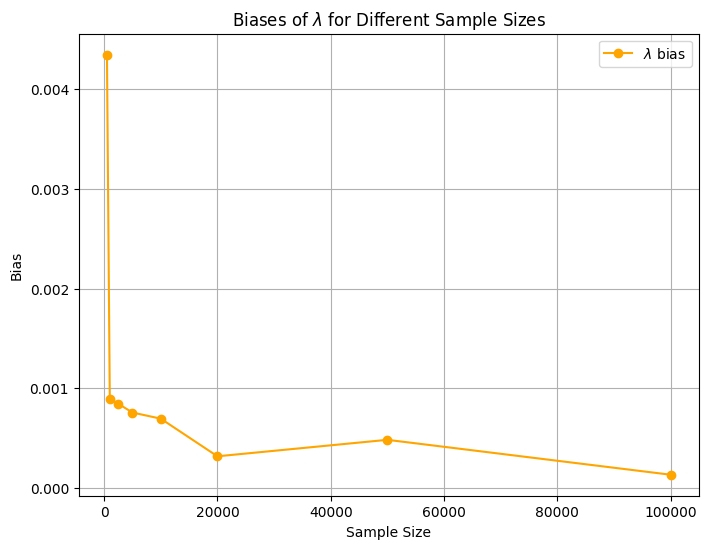

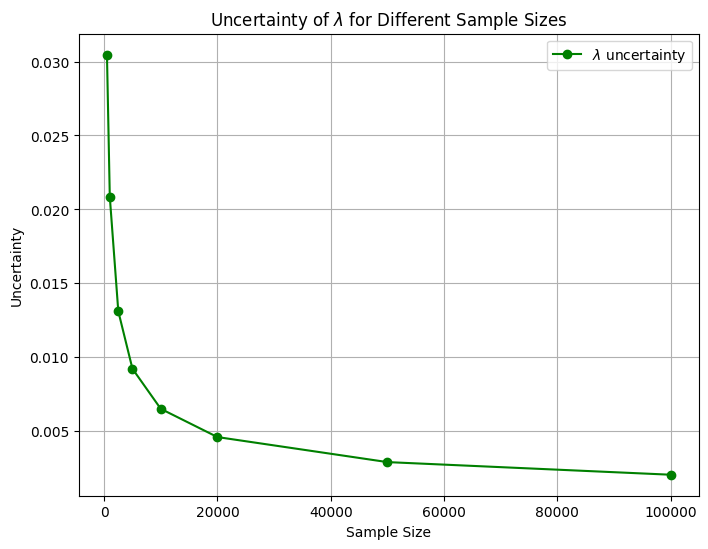

In [26]:
# Plot estimates of lambda for different sample sizes
plt.figure(figsize=(8, 6))
plt.plot(sample_sizes, simulation_lmda_values, 'o-', label='$\\lambda$ estimates')
plt.axhline(lmda_hat, color='red', linestyle='--', label='True $\\lambda$')
plt.xlabel('Sample Size')
plt.ylabel('$\\lambda$')
plt.title('Estimates of $\\lambda$ True Values for Different Sample Sizes')
plt.legend()
plt.grid(True)

# Plot biases of lambda for different sample sizes
plt.figure(figsize=(8, 6))
plt.plot(sample_sizes, simulation_lmda_bias, 'o-', label='$\\lambda$ bias', color='orange')
plt.xlabel('Sample Size')
plt.ylabel('Bias')
plt.title('Biases of $\\lambda$ for Different Sample Sizes')
plt.legend()
plt.grid(True)

# Plot uncertainties of lambda for different sample sizes
plt.figure(figsize=(8, 6))
plt.plot(sample_sizes, simulation_lmda_uncertainty, 'o-', label='$\\lambda$ uncertainty', color='green')
plt.xlabel('Sample Size')
plt.ylabel('Uncertainty')
plt.title('Uncertainty of $\\lambda$ for Different Sample Sizes')
plt.legend()
plt.grid(True)


## Question f

Using the samples produced above, perform an extended maximum likelihood fit in just the $X$ variable and use it to produce `sWeights` which project out the signal
 density in 𝑌. Then use an estimation method of your choice to determine the decay
 constant 𝜆 based on the weighted sample in 𝑌. Compare the bias and the
 uncertainty to your findings from the previous part.

In [27]:
def density_X(x, N, mu=3, sigma=0.3, beta=1, m=1.4, f=0.6):
    return N, N*f * g_s(x, beta, m, mu, sigma) + N*(1-f) * g_b(x)

In [28]:
def cdf_Y(y, lmda):
    return truncexpon.cdf(y, xmin=0, xmax=10, loc=0., scale=1/lmda)

In [34]:
sweights_lmda_values = []
sweights_lmda_bias = []
sweights_lmda_uncertainty = []

In [35]:
for sample_size in sample_sizes:

    # Generate the dataset
    N = np.random.poisson(sample_size)

    Ns = int(f * N)
    Nb = int((1-f) * N)

    g_s_model = sp_crystalball(beta=beta_hat, m=m_hat, loc=mu_hat, scale=sigma_hat)
    g_s_uniform_samples = np.random.uniform(g_s_model.cdf(0), g_s_model.cdf(5), size=Ns)
    Xs = g_s_model.ppf(g_s_uniform_samples)

    g_b_uniform_samples = np.random.uniform(uniform.cdf(0, a = 0, w = 5), uniform.cdf(5, a = 0, w = 5), size=Nb)
    Xb = uniform.ppf(g_b_uniform_samples, a = 0, w = 5)

    Ys = truncexpon.rvs(xmin=0, xmax=10, loc=0, scale=1/lmda_hat, size=Ns, random_state=None)
    Yb = truncnorm.rvs(xmin=0, xmax=10, loc=mu_b_hat, scale=sigma_b_hat, size=Nb, random_state=None)

    sevs = np.column_stack((Xs, Ys))
    bevs = np.column_stack((Xb, Yb))

    simulation_dataset = np.concatenate((sevs, bevs))

    # Fit the X-only model to the x values of the dataset 
    nll_simulation = ExtendedUnbinnedNLL(simulation_dataset[:,0], density_X)
    mi_simulation = Minuit(nll_simulation, mu=mu_hat, sigma=sigma_hat, beta=beta_hat, m=m_hat, f=f_hat, N=sample_size)

    mi_simulation.migrad()
    mi_simulation.hesse()

    # Set sWeighter
    sf = lambda x: g_s(x, mi_simulation.values['beta'], mi_simulation.values['m'], mi_simulation.values['mu'], mi_simulation.values['sigma'])
    bf = lambda x: g_b(x)
    sy = mi_simulation.values['N'] * mi_simulation.values['f']
    by = mi_simulation.values['N'] * (1 - mi_simulation.values['f'])

    xrange = (0, 5)
    yrange = (0, 10)

    sweighter = SWeight( simulation_dataset[:,0], pdfs=[sf,bf], yields=[sy,by], discvarranges=(xrange,))

    # Calculate the signal Weights and the signal Weights squared of y (and bin edges)
    sw = sweighter.get_weight(0, simulation_dataset[:,0])
    bw = sweighter.get_weight(1, simulation_dataset[:,0])

    bins = 50

    ysw, ye = np.histogram( simulation_dataset[:,1], bins=bins, range=yrange, weights=sw )
    ybw, ye = np.histogram( simulation_dataset[:,1], bins=bins, range=yrange, weights=bw )
    ysw2, ye = np.histogram( simulation_dataset[:,1], bins=bins, range=yrange, weights=sw**2 )
    ybw2, ye = np.histogram( simulation_dataset[:,1], bins=bins, range=yrange, weights=bw**2 )

    cy = 0.5*(ye[1:]+ye[:-1]) # bin centers

    # Use binned likelihood method to fit
    nll_y = BinnedNLL(ysw, ye, cdf_Y)
    mi_y = Minuit(nll_y, lmda=lmda_hat)
    mi_y.migrad()
    mi_y.hesse()

    # Store the estimates and errors of the parameters
    sweights_lmda_values.append(mi_y.values['lmda'])
    sweights_lmda_bias.append(mi_y.values['lmda'] - lmda_hat)
    sweights_lmda_uncertainty.append(mi_y.errors['lmda'])



    PDF normalisations:
	 0 0.9999999998201389
	 1 1.0000000000000002
    Integral of w*pdf matrix (should be close to the
                identity):
	[[ 1.00050438 -0.00557304]
	 [-0.00562048  0.99942588]]
    Check of weight sums (should match yields):
	Component  | sWeightSum |   Yield    |   Diff    |
	---------------------------------------------------
	  0        |   251.6678 |   251.6678 |     0.00% |
	  1        |   226.6361 |   226.6361 |     0.00% |
    PDF normalisations:
	 0 0.9999999998153946
	 1 1.0000000000000002
    Integral of w*pdf matrix (should be close to the
                identity):
	[[ 1.0009757  -0.00132693]
	 [-0.0010389   1.00133218]]
    Check of weight sums (should match yields):
	Component  | sWeightSum |   Yield    |   Diff    |
	---------------------------------------------------
	  0        |   520.9264 |   520.9264 |     0.00% |
	  1        |   430.0429 |   430.0429 |    -0.00% |
    PDF normalisations:
	 0 1.0000000000169627
	 1 1.0000000000000002
  

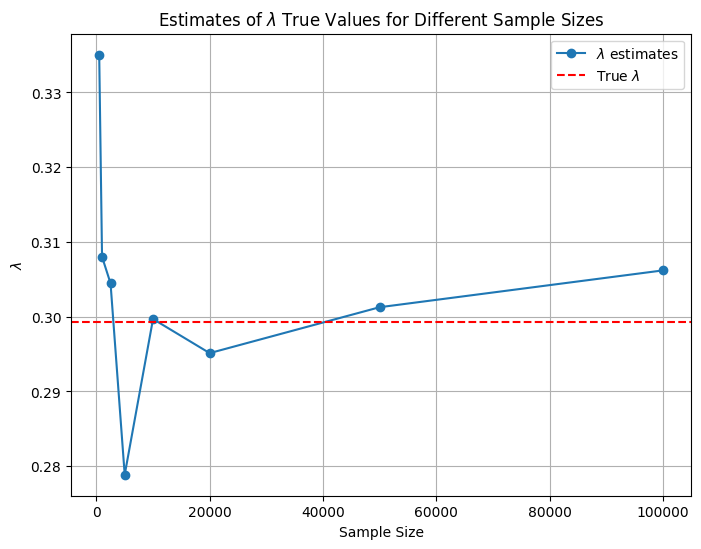

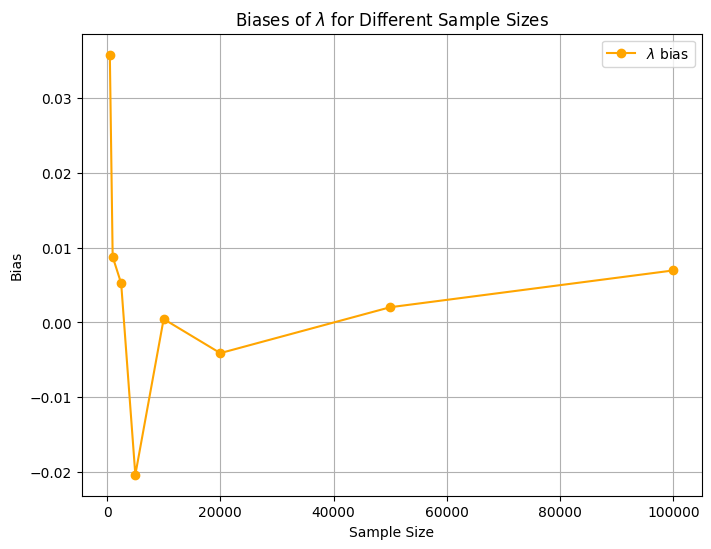

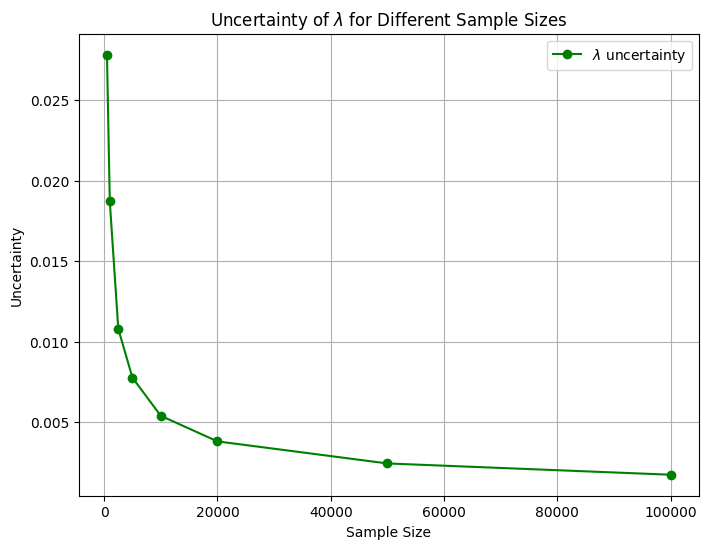

In [36]:
plt.figure(figsize=(8, 6))
plt.plot(sample_sizes, sweights_lmda_values, 'o-', label='$\\lambda$ estimates')
plt.axhline(lmda_hat, color='red', linestyle='--', label='True $\\lambda$')
plt.xlabel('Sample Size')
plt.ylabel('$\\lambda$')
plt.title('Estimates of $\\lambda$ True Values for Different Sample Sizes')
plt.legend()
plt.grid(True)

plt.figure(figsize=(8, 6))
plt.plot(sample_sizes, sweights_lmda_bias, 'o-', label='$\\lambda$ bias', color='orange')
plt.xlabel('Sample Size')
plt.ylabel('Bias')
plt.title('Biases of $\\lambda$ for Different Sample Sizes')
plt.legend()
plt.grid(True)

plt.figure(figsize=(8, 6))
plt.plot(sample_sizes, sweights_lmda_uncertainty, 'o-', label='$\\lambda$ uncertainty', color='green')
plt.xlabel('Sample Size')
plt.ylabel('Uncertainty')
plt.title('Uncertainty of $\\lambda$ for Different Sample Sizes')
plt.legend()
plt.grid(True)
